In [15]:
from lxml import etree
import pdb
import re
from xml.dom import minidom
import numpy as np
import pdb
from skimage.draw import polygon
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd


In [43]:
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Conv2D, Reshape,Conv2DTranspose,Flatten, MaxPooling2D,Dropout,UpSampling2D,concatenate
from tensorflow.keras.utils import to_categorical

In [17]:
path='./cubicasa5k/high_quality/17/F1_scaled.png'
#svg=minidom.parse(path)
fplan=cv2.imread(path)
fplan=cv2.cvtColor(fplan,cv2.COLOR_BGR2RGB)
fplan.shape

(1270, 814, 3)

In [18]:
#get train list
train_path='./cubicasa5k/train.txt' 
data_folder='./cubicasa5k'
data_path=['./cubicasa5k'+i for i in np.genfromtxt(train_path,dtype='str')]

In [33]:
test_path='./cubicasa5k/test.txt' 
data_path2 = ['./cubicasa5k'+i for i in np.genfromtxt(test_path,dtype='str')]

In [20]:
test=data_path[5]
test

'./cubicasa5k/high_quality_architectural/1269/'

In [21]:

class Wall:
    def __init__(self, id, end_points, direction, width, name):
        self.id = id
        self.name = name
        self.end_points = end_points
        self.direction = direction
        self.max_width = width
        self.min_width = width

    def change_end_points(self):
        if self.direction == 'V':
            self.end_points[0][0] = np.mean(np.array(self.min_coord))
            self.end_points[1][0] = self.end_points[0][0]
        elif self.direction == 'H':
            self.end_points[0][1] = np.mean(np.array(self.min_coord))
            self.end_points[1][1] = self.end_points[0][1]

    def get_length(self, end_points):
        return calc_distance(end_points[0], end_points[1])
class PolygonWall(Wall):
    def __init__(self, e, id, shape=None):
        self.id = id
        self.name = e.getAttribute('id')
        self.X, self.Y = self.get_points(e)
        if abs(max(self.X)-min(self.X)) < 4 or abs(max(self.Y)-min(self.Y)) < 4:
            # wall is too small and we ignore it.
            raise ValueError("small wall")
        if shape:
            self.X = np.clip(self.X, 0, shape[1])
            self.Y = np.clip(self.Y, 0, shape[0])
        # self.X, self.Y = self.sort_X_Y(self.X, self.Y)
        self.rr, self.cc = polygon(self.Y, self.X)
        #direction = self.get_direction(self.X, self.Y)
        #end_points = self.get_end_points(self.X, self.Y, direction)
        #self.min_width = self.get_width(self.X, self.Y, direction)
        #self.max_width = self.min_width

        #Wall.__init__(self, id, end_points, direction, self.max_width, self.name)
        #self.length = self.get_length(self.end_points)
        #self.center = self.get_center(self.X, self.Y)
        #self.min_coord, self.max_coord = self.get_width_coods(self.X, self.Y)

    def get_points(self, e):
        pol = next(p for p in e.childNodes if p.nodeName == "polygon")
        points = pol.getAttribute("points").split(' ')
        points = points[:-1]

        X, Y = np.array([]), np.array([])
        for a in points:
            x, y = a.split(',')
            X = np.append(X, np.round(float(x)))
            Y = np.append(Y, np.round(float(y)))

        return X, Y



In [22]:
def clip_outside( rr, cc,shape):
        s = np.column_stack((rr, cc))
        s = s[s[:, 0] < shape[0]]
        s = s[s[:, 1] < shape[1]]

        return s[:, 0], s[:, 1]
def extract_wall(data_path):
    fplan=cv2.imread(data_path+'F1_scaled.png')
    fplan=cv2.cvtColor(fplan,cv2.COLOR_BGR2RGB)
    height,width,nchannel=fplan.shape
    #fplan=np.moveaxis(fplan,-1,0)
    svg=minidom.parse(data_path+'model.svg')
    walls=np.zeros((height,width),dtype=np.uint8)
    wall_id=0
    shape=height,width
    for e in svg.getElementsByTagName('g'):
        try:
            if e.getAttribute("id")=="Wall":
                wall = PolygonWall(e, wall_id, shape)
                wall.rr, wall.cc = clip_outside(wall.rr, wall.cc,shape)
                walls[wall.rr, wall.cc] = 1
                wall_id+=1
                #plt.imshow(walls)
                #plt.show()
            if e.getAttribute("id")=="Railing":
                wall = PolygonWall(e, wall_id, shape)
                wall.rr, wall.cc = clip_outside(wall.rr, wall.cc,shape)
                walls[wall.rr, wall.cc] = 0.1
                wall_id+=1
        except ValueError as k:
            if str(k)=='small wall':
                continue
    input_image=cv2.resize(fplan,(256,256))
    wall_target=cv2.resize(walls,(256,256))
    return input_image,wall_target
    
    

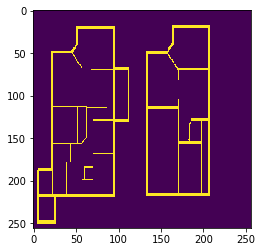

In [23]:
x=extract_wall(test)
plt.imshow(x[1])

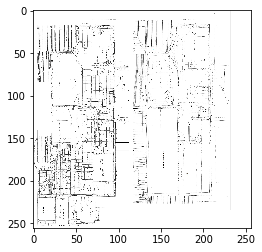

In [24]:
re = cv2.imread(test+'F1_scaled.png')
re = cv2.resize(re,(256,256))
plt.imshow(re)

In [25]:
def our_generator():
    for i in range(len(data_path)):
        x = extract_wall(data_path[i])[0]
        y = extract_wall(data_path[i])[1]
        y = np.expand_dims(y, axis=-1)
        
        yield x,y


dataset=tf.data.Dataset.from_generator(our_generator,output_types=(tf.float32, tf.int16),output_shapes =(tf.TensorShape([256,256,3]),tf.TensorShape([256,256,1])))
train_df=dataset.batch(32).prefetch(1)


for i in train_df.take(5):
    print(i[0].shape)
    

(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)


In [26]:
def our_generator2():
    for i in range(len(data_path2)):
        x = extract_wall(data_path2[i])[0]
        y = (extract_wall(data_path2[i])[1])
        y = np.expand_dims(y, axis=-1)
        yield x,y

dataset2=tf.data.Dataset.from_generator(our_generator2,output_types=(tf.float32, tf.int16),output_shapes =(tf.TensorShape([256,256,3]),tf.TensorShape([256,256,1])))
val_df=dataset2.batch(32).prefetch(1)


for i in val_df.take(5):
    print(i[1].shape)
    

(32, 256, 256, 1)
(32, 256, 256, 1)
(32, 256, 256, 1)
(32, 256, 256, 1)
(32, 256, 256, 1)


In [27]:
type(train_df)
type(val_df)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

In [30]:
X=np.empty((len(data_path),256,256,3))
Y=np.empty((len(data_path),256,256,1))
for i in range(len(data_path)):
    if i %100==0:
        print(i)
    X[i]=extract_wall(data_path[i])[0]/255.
    Y[i]=np.expand_dims(extract_wall(data_path[i])[1], axis=-1)


    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100


In [31]:
outfile = './saved_arrays/train_X.npy'
outfile2 = './saved_arrays/train_Y.npy'

np.save(outfile, X)
#X = np.load(outfile)

np.save(outfile2, Y)
#Y = np.load(outfile2)

In [ ]:
X2=np.empty((len(data_path2),256,256,3))
Y2=np.empty((len(data_path2),256,256,1))
for i in range(len(data_path2)):
    if i %100==0:
        print(i)
    X2[i]=extract_wall(data_path2[i])[0]/255.
    Y2[i]=np.expand_dims(extract_wall(data_path2[i])[1], axis=-1)


In [36]:
outfile3 = './saved_arrays/test_X.npy'
outfile4 = './saved_arrays/test_Y.npy'

np.save(outfile3, X2)
#X2 = np.load(outfile3)

np.save(outfile4, Y2)
#Y2 = np.load(outfile3)

## Models

In [25]:
input_size =(256,256,3)
output_size = (256,256)

model = Sequential() # Create sequential model

n_filters = 64
# Add network layers
model.add(Conv2D(n_filters, (3, 3), activation='relu', padding='same', input_shape=input_size))
model.add(Conv2D(n_filters, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(n_filters, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(32,(5,5),padding='same', activation=tf.nn.leaky_relu, strides=(2, 2)))
model.add(Conv2DTranspose(1,(5,5),padding='same', activation=tf.nn.sigmoid))
model.add(tf.keras.layers.Reshape((256,256)))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 256, 256, 32)      51232     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 256, 1)       8

In [57]:
input_size =(256,256,3)

model = Sequential()
model.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=input_size))
model.add(Conv2D(1, (3, 3), padding='same', activation=tf.nn.sigmoid))
model.add(tf.keras.layers.Reshape((256,256)))
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 8)       224       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 1)       73        
_________________________________________________________________
reshape (Reshape)            (None, 256, 256)          0         
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________________


In [68]:
opt = Adam(lr=0.01)
loss = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
history = model.fit(train_df,
                 epochs=3,
                 validation_data = val_df)

In [59]:
#Y = to_categorical(Y)
#Y2 = to_categorical(Y2)
Y = np.load(outfile2)
Y2 = np.load(outfile4)
Y = np.squeeze(Y, axis=(3,))
Y2 = np.squeeze(Y2, axis=(3,))

In [60]:
Y.shape

(4200, 256, 256)

In [ ]:
history2 = model.fit(X, Y, 
                              epochs=10, 
                              verbose=1,
                              batch_size = 32,
                              validation_data=(X2, Y2))

### U-Net Model 

In [67]:
#some segmentation model from https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html

img_input = Input(shape=(256 ,256, 3 ))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

out = Conv2D(1, (1, 1), activation='sigmoid' , padding='same')(conv5)
out = Reshape((256,256))(out)

model= tf.keras.Model(img_input, out)

opt = Adam(lr=0.01)
loss = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [64]:
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

In [ ]:
store_keras_model(model, 'model_1')

In [66]:
#RNN = load_keras_model('model_RNN')